# **Example No 01**

# **Solving Newton Law of Cooling Equation with PINNs**

## Problem Overview

Newton's Law of Cooling describes the rate at which an object exchanges heat with its surroundings. It can be mathematically expressed as the first-order ordinary differential equation:

$$
\frac{dT}{dt} = -k \left(T - T_{\text{ambient}}\right)
$$

where:

- $$T(t)$$ is the temperature of the object at time $$ t $$.
- $$ T_{\text{ambient}} $$ is the ambient temperature (assumed constant).
- \( k \) is the cooling constant (related to the thermal properties of the system).

## Analytical (Exact) Solution

Given an initial temperature \( T_0 = T(0) \), the analytical solution to the above differential equation is:

$$
T(t) = T_{\text{ambient}} + \left(T_0 - T_{\text{ambient}}\right) e^{-kt}
$$


## PINN Approach
Physics-Informed Neural Networks (PINNs) integrate physical laws directly into the neural network training process by incorporating the governing differential equations as part of the loss function. This methodology helps the network to learn from limited data while strictly adhering to physical principles, resulting in physically consistent and robust predictions.

### Key Components of the PINN
- **Boundary Condition:**
$$
T(0) = T_0
$$

- **Physics-informed Loss:** Ensures adherence to the differential equation by minimizing the residual:
$$
\text{Loss}_{\text{physics}} = \left|\frac{dT}{dt} + k(T - T_{\text{ambient}})\right|^2
$$
## Importance of PINNs
PINNs are powerful tools for solving differential equations numerically, especially in situations where data is sparse or traditional numerical methods face difficulties. By embedding physical laws explicitly into neural networks, PINNs improve prediction accuracy and robustness compared to standard machine learning techniques.

This notebook demonstrates the application of a PINN to solve Newton's Law of Cooling, comparing the network's predictions to the exact analytical solution.

Importing Libraries

In [43]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

Initialize Parameters

In [44]:
# Initialize parameters
T_ambient = 25.0   # Ambient temperature (°C)
T_initial = 100.0   # Initial tea temperature (°C)
k = 0.05           # Cooling constant (1/min)

Analytical Solution

In [45]:
# Analytical solution for Newton's Law of Cooling
def exact_solution(T0, Tamb, k, t):
    return Tamb + (T0 - Tamb) * torch.exp(-k * t)


Fully Connected Network

In [46]:
# Define a fully-connected neural network
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(
            nn.Linear(N_INPUT, N_HIDDEN),
            activation()
        )
        self.fch = nn.Sequential(
            *[nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation()) for _ in range(N_LAYERS - 1)]
        )
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

Defining PINNs and Loss Function

In [47]:
# Define the neural network
pinn = FCN(1, 1, 32, 3)

# Boundary condition and physics points
t_boundary = torch.tensor([[0.0]], requires_grad=True)
t_physics = torch.linspace(0, 100, 50).view(-1, 1).requires_grad_(True)

Test Points

In [48]:
# Test points and exact solution
t_test = torch.linspace(0, 100, 50).view(-1, 1)
T_exact = exact_solution(T_initial, T_ambient, k, t_test)

Optimiser

In [49]:
# Optimizer
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)

Training Loop and plotting during training



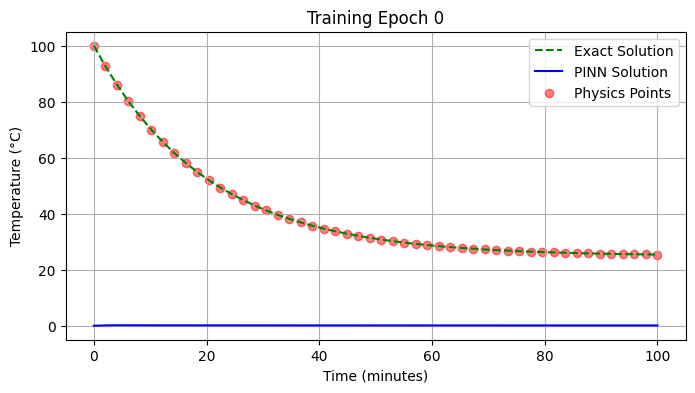

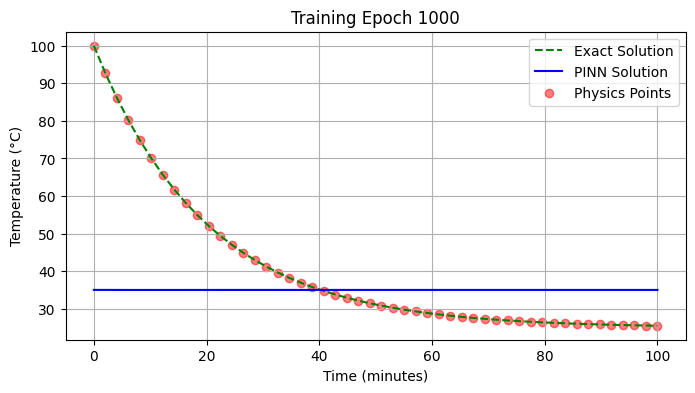

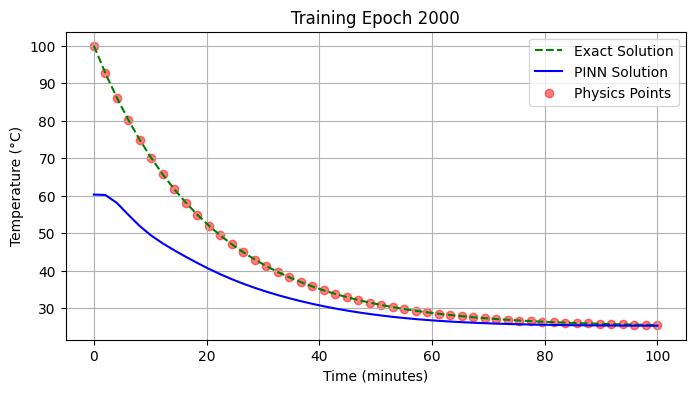

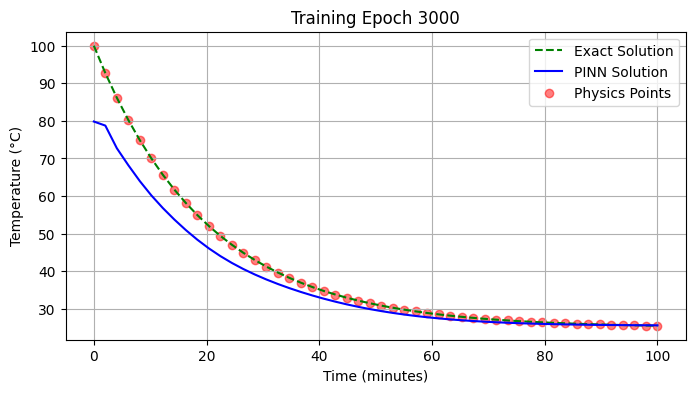

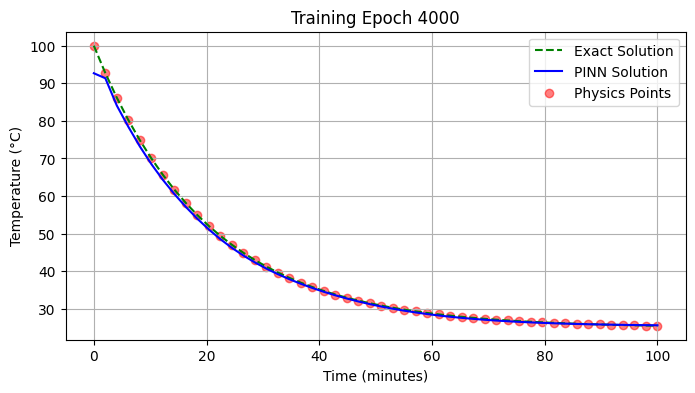

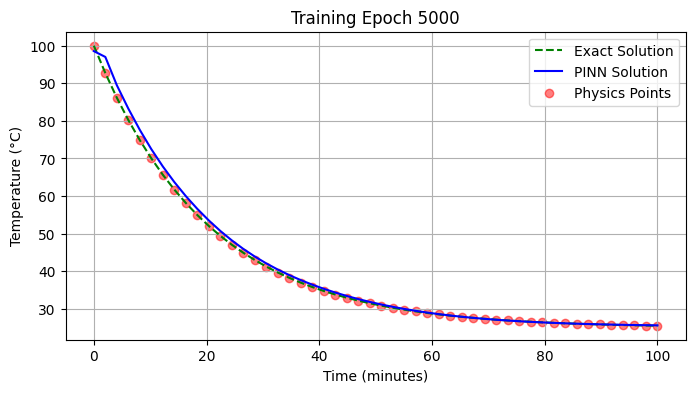

In [50]:
# Training loop
for epoch in range(5001):
    optimizer.zero_grad()

    # Boundary loss
    T0_pred = pinn(t_boundary)
    loss_boundary = (T0_pred - T_initial)**2

    # Physics loss
    T_pred = pinn(t_physics)
    dTdt = torch.autograd.grad(T_pred, t_physics, torch.ones_like(T_pred), create_graph=True)[0]
    loss_physics = torch.mean((dTdt + k * (T_pred - T_ambient))**2)

    # Total loss
    loss = loss_boundary + loss_physics
    loss.backward()
    optimizer.step()

    # Plotting during training
    if epoch % 1000 == 0:
        T_pred_plot = pinn(t_test).detach()
        plt.figure(figsize=(8, 4))
        plt.plot(t_test.numpy(), T_exact.numpy(), 'g--', label="Exact Solution")
        plt.plot(t_test.numpy(), T_pred_plot.numpy(), 'b-', label="PINN Solution")
        plt.scatter(t_physics.detach().numpy(), T_exact[:len(t_physics)].detach().numpy(), color='r', alpha=0.5, label="Physics Points")
        plt.xlabel('Time (minutes)')
        plt.ylabel('Temperature (°C)')
        plt.title(f"Training Epoch {epoch}")
        plt.legend()
        plt.grid(True)
        plt.show()